In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib, copy
from glob import glob
import pickle
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.electromagnetic import FreeVectorPotential, CavityVectorPotential

from matter.atoms import AtomsInBox
from calculator.calculator import Calculator

from utilities.etc import categorizing_result

import animation as an
import analyze_tools.utils as atu
from analyze_tools.monte_carlo import get_colliding_time

from simulation.single import single_collision_simulation
import utilities.reduced_parameter as red
from utilities.etc import moving_average

ROOT = os.path.expanduser('~/OneDrive - Emory/Research Data/mm_polariton/pickle_jar/')

plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({'font.size': 12})

#ROOT = os.path.expanduser('~/OneDrive - Emory/Research data/mm_polariton/pickle_jar')
#assert os.path.isdir(ROOT)

Epsilon (erg) 1.6538969109051514e-14
Reduced epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.3825301204819278 ; 1.9116465863453815
CGS epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.6538969109051514e-14 ; 2.286562295498387e-14 ; 3.161666383899004e-14
######################
Length multiple - Sigma (cm) 3.41e-08
Reduced sigma (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.095307917888563 ; 1.190615835777126
######################
Mass multiples (g) 6.633521465546083e-23
Reduced Mass (Ar, Xe): 1.0 ; 3.286597576849905
######################
Dipole unit multiple (statC . cm) 8.09814943451058e-19
Reduced dipole parameter:
mu0 =  0.08920009870622121
a =  7.8952761266316935
d0 =  1.1018059229945159
d7 =  0.030776244402154505
CGS dipole parameter:
mu0 =  7.223557288960733e-20
a = 2.32E+08
d0 =  3.757158197411299e-08
######################
Time 2.159594587679023e-12
Velocity multiple (cm/s) 15790.00067630667
Temperature  119.79126562255514
######################
c:  1899936.5874009002
Epsilon parameters matrix 
[[1.         1.3825301

In [2]:
#
# DEFINING FUNCTION
## WARNING: NEXT CELL WILL RUN SIMULATIONS
#


Lxy = 3e7; Lz = 3e3
def get_ArXePair(
    d_arxe, v_ar = 0, h = 0, n_pairs = 1, Lxy=Lxy, Lz=Lz, random_origin = False):
    """
    """
    atoms = AtomsInBox(
        Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
        mass_dict = red.mass_dict)

    v_xe = - v_ar / np.sqrt(red.mass_dict['Xe'])

    for i in range(n_pairs):
        if i == 0 and not random_origin:
            r0 = np.zeros(3)
        elif random_origin:
            r0 = np.hstack(
                [
                    np.random.uniform(-Lxy/2+100, Lxy/2-100, size = 2), 
                    #np.zeros(2),
                    np.random.uniform(-Lz/2+100, Lz/2-100)]
            )
        atoms.add(
                elements = ["Ar"],
                r = np.array([[0.0, h, -d_arxe/2]]) + r0,
                r_dot = np.array([[0.0, 0.0, v_ar]])# / np.sqrt(2)
                )
        
        atoms.add(
                elements = ["Xe"],
                r = np.array([[0.0,0.0,d_arxe/2]]) + r0,
                r_dot = np.array([[0.00, 0.00, v_xe]])# / np.sqrt(2)
                )
    
    idxAr = atoms.element_idx(element = "Ar")
    idxXe = atoms.element_idx(element = "Xe")
    epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)
    
    # calculator to the atoms object
    atoms.add_calculator(
        calculator_class = Calculator,
        calculator_kwargs = {
            "epsilon": epsilon_mat, "sigma" : sigma_mat, 
            "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
            "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
        })
    
    atoms.update_distance()
    
    return atoms

def get_field(coup_str, amplitude, T = None, mode = False, Lxy = Lxy, Lz = Lz, field = 'cavity'):
    if mode == 'multi':
        k_vector_int = np.array(
            [[i,0,0] for i in range(1,100)]
            ,dtype=np.float64)
    elif isinstance(mode, int):
        k_vector_int = np.array([[mode,0,0]])
    elif isinstance(mode, list):
        k_vector_int = np.array(
            [[i,0,0] for i in mode], 
            dtype = np.float64)
    else:
        raise Exception('Mode have to be either "multi" or an integer!')
    
    if field == 'cavity':
        VectorPotentialClass = CavityVectorPotential
    elif field == 'free':
        VectorPotentialClass = FreeVectorPotential
    
    Afield = VectorPotentialClass(
            k_vector_int = k_vector_int, amplitude = amplitude,
            Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = coup_str, T = T / red.temp
            )

    return Afield

def get_radprofile(rd, windows = 10):
    Afield = rd['field']
    
    rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "ev") 
    omega = red.convert_wavenumber(Afield.k_val)
    omega_profile, final_rad_profile = atu.profiling_rad(omega, rad_energy)
    
    sorted_idx = np.argsort(omega_profile)

    if windows == 0:
        omega_profile = np.array(omega_profile)[sorted_idx] 
        final_rad_profile = np.array(final_rad_profile)[sorted_idx]
    else:
        omega_profile, final_rad_profile = moving_average(
            np.array(omega_profile)[sorted_idx], 
            np.array(final_rad_profile)[sorted_idx], windows)

    return omega_profile, final_rad_profile

In [ ]:
# 
# CALCULATING SPECTRA
# Run simulation of head on collision coupled to FREE field 
# at various total energy as temperature 
# 

result_dict = {}
velocity_dict = {}

M_Xe = red.mass_dict['Xe']

for T in tqdm.tqdm(list(range(25,860,25))):
    
    vt = np.sqrt((T * red.boltzmann / red.epsilon) )
    atoms = get_ArXePair(d_arxe = 6, h = 0.0 , v_ar = vt, n_pairs = 1)
    
    field = get_field(amplitude = 'zero', mode = list(range(1,300)), coup_str = 1, Lz = Lxy, field = 'free' , T = T)
        
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)

    result_dict.update({T : rd})
    velocity_dict.update({T : (vt, vt / np.sqrt(M_Xe))})

In [ ]:
#
# PLOTTING SPECTRA
#

fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()

fig = [fig1, fig2]
ax = [ax1, ax2]

total = 0
total100 = 0

prob_list292 = []
prob_list100 = []

for T in result_dict.keys():
    prob_list292.append(T * np.exp(- T / 292))
    prob_list100.append(T * np.exp(- T / 100))

prob_list292 = np.array(prob_list292)
prob_list292 = prob_list292 / np.sum(prob_list292)
prob_list100 = np.array(prob_list100)
prob_list100 = prob_list100 / np.sum(prob_list100)

for i, (T,rd) in enumerate(result_dict.items()):
    
    omega_profile, final_rad_profile = atu.field_spectra(
        rd, 
        convert_function = {'energy':red.convert_energy, 'wavenumber':red.convert_wavenumber},
        mode = 'std'
    )
    final_rad_profile *= 1e25
    
    final_rad_profile = final_rad_profile[omega_profile > 5]
    omega_profile = omega_profile[omega_profile > 5]
    
    total += final_rad_profile * prob_list292[i]
    total100 += final_rad_profile * prob_list100[i]

    if T % 100 == 0:
        ax[0].plot(
            omega_profile, final_rad_profile, label = '{} K'.format(T), 
            linestyle = 'dashdot' if i >= 35 else None)

ax[1].plot(omega_profile, total, label = 'Scaled total spectrum')
  
tax = ax[1].twinx()
exp_data = pd.read_csv('data/plot-data.csv')
tax.scatter(
    exp_data.loc[:,'x'],
    exp_data.loc[:,' y'],
    s = 5, alpha = 0.5, c = 'black'
)
ax[1].scatter([],[], c = 'black', label = 'Exp. @ 292K')

ax[0].set_ylabel(r"I($\omega$) $(10^{-25} eV)$")
ax[1].set_ylabel(r"Sum of scaled EM field energy $(10^{-25} eV)$")
ax[0].set_xlabel(r"Wavenumber ($cm^{-1}$)")
ax[1].set_xlabel(r"Wavenumber ($cm^{-1}$)")

tax.set_ylabel(r'Exp. absorption ($10^{-6}$ cm$^{-1}$ amagat$^{-2})$')

ax[0].legend()#loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=4)
ax[1].legend()

#"""
ax[0].set_ylim(-0.00, 0.72)
ax[1].set_ylim(-0.00, 0.44)
tax.set_ylim(-0.00,2.55)
#"""
ax[0].set_xlim(0.0, 250)
ax[1].set_xlim(0.0, 250)

ax[0].set_title('Free-space Spectra of Diatomic Head-on Collisions')

fig[0].savefig('MSfig/figure/free_spectrum_singleT.jpeg',dpi = 600, bbox_inches = 'tight')

In [ ]:
#
# Record (trajectory @ 40K, highest temperature that Ar-Xe complex form, previous temperature)
#

np.random.seed(20)

single_collision_multimode_data = {}

prompt = input('Load file?(Y)/N')
if prompt != 'N':
    raise Exception
    
iplist = [0.0]
Tlist = list(np.arange(10, 155, 1))

cavity_init = 'boltzmann'
save_path = 'pickle_jar/single_collision_{}_cavity'.format(cavity_init)
print(save_path)
assert os.path.isdir(save_path)

result_dict = {}
for ct in [20, 10]:
    result_dict_ = {}
    for h in iplist:
        print('h = ', h, ' coupling strength = ', ct)
        T_break = None

        foo = {}
        
        for T in Tlist:
            print("{}/{}".format(T, Tlist[-1]))
            collide_time_list = []
            
            for i in tqdm.tqdm(range(100)):

                vt = np.sqrt((T * red.boltzmann / red.epsilon) )
                # T = K_Ar + K_Xe = 2K_Ar = m_Ar v_Ar^2 (equal kinetic energy of Argon and Xenon)
                atoms = get_ArXePair(d_arxe = 6, h = h , v_ar = vt, n_pairs = 1, random_origin = True)
                
                field = get_field(
                    amplitude = cavity_init, T = T,
                    mode = list(range(1,260)), coup_str = ct * Lxy, Lz = Lz, field = 'cavity'
                )
                    
                t, rd = single_collision_simulation(
                    0, h = 1e-2, atoms = atoms, field = field, potential_threshold = 1e-4,
                    max_steps = 10000, verbose = False, record_every = 1) # 10000 it ~ 200 ps

                collide_time = get_colliding_time(rd['atoms'], 0)
                
                collide_time_list += collide_time

            #foo.update({T:rd})
            foo.update({T:collide_time_list})
            
        result_dict_.update({h : foo})
    result_dict.update({ct : result_dict_})

with open(save_path + '/collide_time_dict100.pkl','wb') as handle:
    pickle.dump(result_dict, handle)
            

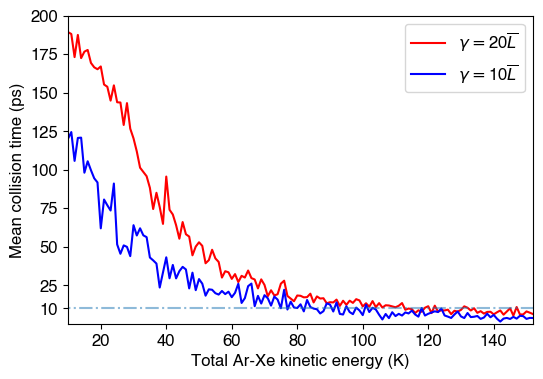

In [6]:
ROOT = 'pickle_jar'
with open(ROOT+'/single_collision_boltzmann_cavity/collide_time_dict100.pkl', 'rb') as handle:
    result_dict = pickle.load(handle)

color_list = ['blue', 'red']
label = {10:"10", 20:"20"}

assoc_lim = 10

fig,ax = plt.subplots(1, figsize = (6,4))
for i, (coup_str, coup_str_dict) in enumerate(result_dict.items()):
    mean_collide_time = []
    std_collide_time = []
    Tlist = []
    h_dict = coup_str_dict[0.0]
    for t, collide_tlist in h_dict.items():
        Tlist.append(t)
        mean_collide_time.append(np.mean(collide_tlist))
        std_collide_time.append(np.std(collide_tlist))

    mean_collide_time = np.array(mean_collide_time)
    std_collide_time = np.array(std_collide_time)

    if coup_str == 20: i = 1
    elif coup_str == 10: i = 0
    #ax.plot(Tlist, mean_collide_time)
    """
    ax.fill_between(
        np.array(Tlist) + 0.4 * i, 
        mean_collide_time + std_collide_time,
        mean_collide_time - std_collide_time, 
        color = color_list[i],
        alpha = 0.05
    )
    #"""
    ax.plot(
        np.array(Tlist), mean_collide_time, 
        color = color_list[i],
        label = r'$\gamma = ${}'.format(label[coup_str]) + r'$\overline{L}$'
    )
    ax.set_ylim(0, 200)

ax.plot(
    np.linspace(0,170,100),
    [assoc_lim] * 100, linestyle='dashdot', alpha = 0.5
)


ax.set_xlim(10, 152)

foo = list(ax.get_yticks())
foo.remove(0)
ax.set_yticks(foo + [assoc_lim])

#ax.set_xticks(list(ax.get_xticks()) + [0])

#ax[0].set_ylabel(r'Ar-Xe distance (nm)')
ax.set_ylabel(r'Mean collision time (ps)')

ax.set_xlabel('Total Ar-Xe kinetic energy (K)')
ax.legend()

fig.savefig('MSfig/figure/boltzmann_collision_time.jpeg', dpi = 600, bbox_inches = 'tight')

In [ ]:
#
# Record (trajectory @ 40K, highest temperature that Ar-Xe complex form, previous temperature)
#

single_collision_multimode_data = {}

prompt = input('Load file?(Y)/N')
if prompt != 'N':
    raise Exception
    
iplist = [0.0, 0.3, 0.6, 0.9, 1.2]
Tlist = list(np.arange(10, 150, 5))

cavity_init = 'boltzmann'
save_path = 'pickle_jar/single_collision_{}_cavity'.format(cavity_init)
print(save_path)
assert os.path.isdir(save_path)

for ct in [20, 15, 10]:
    result_dict = {}
    for h in iplist:
        print('h = ', h, ' coupling strength = ', ct)
        T_break = None

        foo = {}
        
        for T in tqdm.tqdm(Tlist[::-1]):

            vt = np.sqrt((T * red.boltzmann / red.epsilon) )
            # T = K_Ar + K_Xe = 2K_Ar = m_Ar v_Ar^2 (equal kinetic energy of Argon and Xenon)
            atoms = get_ArXePair(d_arxe = 6, h = h , v_ar = vt, n_pairs = 1)
            
            field = get_field(
                amplitude = cavity_init, T = T,
                mode = list(range(1,100)), coup_str = ct * Lxy, Lz = Lz, field = 'cavity'
            )
                
            t, rd = single_collision_simulation(
                0, h = 1e-2, atoms = atoms, field = field, potential_threshold = 1e-4,
                max_steps = 10000, verbose = False, record_every = 1) # 10000 it ~ 200 ps

            foo.update({T:rd})
            
        result_dict.update({h : foo})

    with open(save_path + '/coup_str_{}.pkl'.format(ct),'wb') as handle:
        pickle.dump(result_dict, handle)
            

In [ ]:
np.flip(np.arange(110,120, 0.1))

In [ ]:
collide_time

In [ ]:
#
# Simulation of single collisions at various temperature
# The enumeration over all collision temperature will be break if a collision have time < 10ps
# thus suitable for simulation with cavity initiared with zero amplitude
#

single_collision_multimode_data = {}

prompt = input('Load file?(Y)/N')
if prompt != 'N':
    raise Exception
    
iplist = np.arange(0,1.50,0.05)
Tlist = list(np.arange(10, 120, 1))

cavity_init = 'zero'
save_path = 'pickle_jar/single_collision_{}_cavity_'.format(cavity_init)
print(save_path)
assert os.path.isdir(save_path)

for ct in [20]:
    foo = {}

    result_dict = {}
    
    for h in iplist:
        print('h = ', h, ' coupling strength = ', ct)

        while True:
            T -= 0.1
            print('current T {:.2f}: '.format(T), ' current h: ', h)

            vt = np.sqrt((T * red.boltzmann / red.epsilon) )
            atoms = get_ArXePair(d_arxe = 6, h = h , v_ar = vt, n_pairs = 1)
            
            field = get_field(
                amplitude = cavity_init, T = T,
                mode = list(range(1,260)), coup_str = ct * Lxy, Lz = Lz, field = 'cavity'
            )
                
            t, rd = single_collision_simulation(
                0, h = 1e-2, atoms = atoms, field = field, potential_threshold = 1e-4,
                max_steps = 10000, verbose = False, record_every = 1) # 10000 it ~ 200 ps

            collide_time, _ = get_colliding_time(rd['atoms'], dipole_threshold = 0)
            collide_time = collide_time[0]
            print('collide time (ps) = ', collide_time)

            if collide_time > 200: 
                num_iter = len(rd['atoms'].trajectory['t'])
                print('break @ {} K, with collide time {:.2f}ps, {} iterations'.format(T, collide_time, num_iter))
                result_dict.update({h : {'break T':T, 'result_dict':rd}})
                break

    with open(save_path + '/coup_str_{}_.pkl'.format(ct),'wb') as handle:
        pickle.dump(result_dict, handle)

In [ ]:
PATH = 'pickle_jar/single_collision_zero_cavity_/coup_str_20_.pkl'

with open(PATH,'rb') as handle:
    result_dict = pickle.load(handle)

In [ ]:
ip_list = []
Tlist = []
for h, rd in result_dict.items():
    ip_list.append(h)
    Tlist.append(rd['break T'])

ip_list = np.array(ip_list)
ip_list *= red.sigma * 10**8
Tlist = np.array(Tlist)
fig,ax = plt.subplots()

ax.plot(ip_list, Tlist, linewidth = 0.5)
ax.scatter(ip_list, Tlist)
ax.set_xlabel("Impact parameters (Angstrom)")
ax.set_ylabel("Collision energy threshold (K)")
ax.set_xlim(-0.05,5)
ax.set_ylim(19,120)
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))

fig.savefig('MSfig/figure/ip_vs_k.jpeg',dpi = 600,bbox_inches = 'tight')

In [ ]:
for i, file in enumerate(glob('pickle_jar/single_collision_zero_cavity_/*')):
    with open(file, 'rb') as handle:
        print(file)
        result_dict = pickle.load(handle)

        if '20' in file: coup_str = 20
        elif '10' in file: coup_str = 10
        elif '15' in file: coup_str = 15

        for h, rd in result_dict.items():
            print("{} & {} & {} \\\ ".format(coup_str, h, rd['break T']))